# TP sur l'analyse de phrase par HMM

Le but de ce tp est de reprendre les modèles développés en MAPSI pour les appliquer sur un problème d'analyse de séqences.
Nous allons travailler sur le Part-Of-Speech (POS) et optionnellement sur le chunking (le fait de regrouper les groupes nominaux et verbaux dans les phrases). Les données sont issus de CONLL 2000 [https://www.clips.uantwerpen.be/conll2000/chunking/]

Les données sont disponibles en petite quantité (pour comprendre le fonctionnement des outils) puis en grande quantité pour effecter des expériences fiables.

Le but du TP est de prendre en main les données sur une tâche simple (POS/Chunking) puis de donner des perforances sur la tâche de NER. Cette dernière partie est décrite dans l'avant dernière boite de ce TME, elle constitue cependant la plus grosse partie du travail.


In [103]:
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import confusion_matrix

In [2]:
# Chargement des données POS/Chunking
# Cette fonction doit être ré-écrite en v2 pour charger les données NER de connl 2003
def load(filename):
    listeDoc = list()
    with open(filename, "r") as f:
        doc = list()
        for ligne in f:
            #print "l : ",len(ligne)," ",ligne
            if len(ligne) < 2: # fin de doc
                listeDoc.append(doc)
                doc = list()
                continue
            mots = ligne.replace("\n","").split(" ")
            doc.append((mots[0],mots[1])) # mettre mots[2] à la place de mots[1] pour le chuncking
    return listeDoc

In [3]:
# =============== chargement ============
# sous ensemble du corpus => Idéal pour les premiers test
filename = "ressources/conll2000/chtrain.txt" 
filenameT = "ressources/conll2000/chtest.txt" 

# corpus plus gros => Pour valider les perf.
# filename = "ressources/conll2000/train.txt" 
# filenameT = "ressources/conll2000/test.txt" 

alldocs = load(filename)
alldocsT = load(filenameT)

print(len(alldocs)," docs read")
print(len(alldocsT)," docs (T) read")

823  docs read
77  docs (T) read


In [4]:
print(alldocs[0])
print(alldocsT[0])

[('Rockwell', 'NNP'), ('International', 'NNP'), ('Corp.', 'NNP'), ("'s", 'POS'), ('Tulsa', 'NNP'), ('unit', 'NN'), ('said', 'VBD'), ('it', 'PRP'), ('signed', 'VBD'), ('a', 'DT'), ('tentative', 'JJ'), ('agreement', 'NN'), ('extending', 'VBG'), ('its', 'PRP$'), ('contract', 'NN'), ('with', 'IN'), ('Boeing', 'NNP'), ('Co.', 'NNP'), ('to', 'TO'), ('provide', 'VB'), ('structural', 'JJ'), ('parts', 'NNS'), ('for', 'IN'), ('Boeing', 'NNP'), ("'s", 'POS'), ('747', 'CD'), ('jetliners', 'NNS'), ('.', '.')]
[('Confidence', 'NN'), ('in', 'IN'), ('the', 'DT'), ('pound', 'NN'), ('is', 'VBZ'), ('widely', 'RB'), ('expected', 'VBN'), ('to', 'TO'), ('take', 'VB'), ('another', 'DT'), ('sharp', 'JJ'), ('dive', 'NN'), ('if', 'IN'), ('trade', 'NN'), ('figures', 'NNS'), ('for', 'IN'), ('September', 'NNP'), (',', ','), ('due', 'JJ'), ('for', 'IN'), ('release', 'NN'), ('tomorrow', 'NN'), (',', ','), ('fail', 'VB'), ('to', 'TO'), ('show', 'VB'), ('a', 'DT'), ('substantial', 'JJ'), ('improvement', 'NN'), ('from'

# Construction d'un modèle de référence POS à base de dictionnaire

```mot => étiquette``` sans prise en compte de la séquence. Il faudra comparer tout résultat plus lourd à cette référence.

On ne s'intéresse qu'à l'étiquette POS, sachant que le corpus a été décomposé en ```(mot, POS, Chunk)```.

1. Création du dictionnaire d'équivalence à partir du *train*
1. Mesure de l'efficacité en *test*

**Note** certains mots du test sont évidemment inconnus... Sur le plan technique, il faut remplacer:
```
# remplacer
dico[cle] # qui plante en cas de clé inconnue
# par 
dico.get(cle, valeurParDefaut)
```
Sur le plan linguistique, on peut affecter la classe majoritaire à tous les mots inconnus, on aura alors une référence plus forte.

In [8]:
# Construction du dictionnaire 

dico = dict()
for ligne in alldocs :
    for (mot,gram) in ligne :
        dico[mot] = gram 

In [155]:
def gram_plus_frequent(alldocs) :
    liste = []
    dico = dict()
    for ligne in alldocs :
        liste += ligne
    
    for a,b in liste :
        try :
            dico[b] += 1
        except :
            dico[b] = 1
    max_value = max(dico, key=dico.get)
    return max_value


In [156]:
# evaluation des performances en test (et en apprentissage)
gram_plus_freq = gram_plus_frequent(alldocs)
print(gram_plus_freq)
cpt = 0
for ligne in alldocsT :
    for (mot,gram) in ligne :
        if dico.get(mot, gram_plus_freq) == gram :
            cpt += 1
cpt = cpt 
print(cpt)

NN
1527


Check: 1433 bonne réponses en test sur 1896

(1527 avec 'NN' par défaut)

# Analyse de séquence

Je vous donne la correction des TME MAPSI: un apprentissage de HMM et une fonction viterbi. Vous allez devoir l'appliquer sur les données.
Je vous demande seulement de comprendre la signification du paramètre ```eps``` dans l'algorithme HMM. C'est un paramètre important: jouez avec, touver la bonne valeur pour cette application.

Il faut mettre en forme les données pour avoir des indices associés aux mots, sinon, on n'arrivera pas à faire des HMM... Tout le code pour la mise en forme est fourni ci-dessous.
```
 The cat is in the garden => 1 2 3 4 1 5
```

Pour une construction facilité du dictionnaire, on utilisera la méthode ```setdefault```

Afin de produire des analyses qualitative, vous devez malgré tout comprendre le fonctionnement des dictionnaires pour retrouver les mots qui correspondent aux indices.

In [78]:
# allx: liste de séquences d'observations
# allq: liste de séquences d'états
# N: nb états
# K: nb observation

def learnHMM(allx, allq, N, K, initTo1=True,epsilon =1e-3):
    if initTo1:
        eps = epsilon # vous pouvez jouer avec ce paramètre de régularisation
        A = np.ones((N,N))*eps
        B = np.ones((N,K))*eps
        Pi = np.ones(N)*eps
    else:
        A = np.zeros((N,N))
        B = np.zeros((N,K))
        Pi = np.zeros(N)
    for x,q in zip(allx,allq):
        Pi[int(q[0])] += 1
        for i in range(len(q)-1):
            A[int(q[i]),int(q[i+1])] += 1
            B[int(q[i]),int(x[i])] += 1
        B[int(q[-1]),int(x[-1])] += 1 # derniere transition
    A = A/np.maximum(A.sum(1).reshape(N,1),1) # normalisation
    B = B/np.maximum(B.sum(1).reshape(N,1),1) # normalisation
    Pi = Pi/Pi.sum()
    return Pi , A, B

def viterbi(x,Pi,A,B):
    T = len(x)
    N = len(Pi)
    logA = np.log(A)
    logB = np.log(B)
    logdelta = np.zeros((N,T))
    psi = np.zeros((N,T), dtype=int)
    S = np.zeros(T)
    logdelta[:,0] = np.log(Pi) + logB[:,int(x[0])]
    #forward
    for t in range(1,T):
        logdelta[:,t] = (logdelta[:,t-1].reshape(N,1) + logA).max(0) + logB[:,int(x[t])]
        psi[:,t] = (logdelta[:,t-1].reshape(N,1) + logA).argmax(0)
    # backward
    logp = logdelta[:,-1].max()
    S[T-1] = logdelta[:,-1].argmax()
    for i in range(2,T+1):
        S[int(T-i)] = psi[int(S[int(T-i+1)]),int(T-i+1)]
    return S, logp #, delta, psi
 

In [51]:
# alldocs etant issu du chargement des données
# la mise en forme des données est fournie ici
# afin de produire des analyses qualitative, vous devez malgré tout comprendre le fonctionnement des dictionnaires

buf = [[m for m,pos in d ] for d in alldocs]
mots = []
[mots.extend(b) for b in buf]
mots = np.unique(np.array(mots))
nMots = len(mots)+1 # mot inconnu

mots2ind = dict(zip(mots,range(len(mots))))
mots2ind["UUUUUUUU"] = len(mots)

buf2 = [[pos for m,pos in d ] for d in alldocs]
cles = []
[cles.extend(b) for b in buf2]
cles = np.unique(np.array(cles))
cles2ind = dict(zip(cles,range(len(cles))))

nCles = len(cles)

print(nMots,nCles," in the dictionary")

# mise en forme des données
allx  = [[mots2ind[m] for m,pos in d] for d in alldocs]
allxT = [[mots2ind.setdefault(m,len(mots)) for m,pos in d] for d in alldocsT]

allq  = [[cles2ind[pos] for m,pos in d] for d in alldocs]
allqT = [[cles2ind.setdefault(pos,len(cles)) for m,pos in d] for d in alldocsT]

4570 42  in the dictionary


In [60]:
# affichage du premier doc:
print(allx[0])
print(allq[0])
print(allxT[0])
print(allqT[0])

[1140, 814, 563, 11, 1294, 4393, 3855, 2854, 3992, 1362, 4242, 1452, 2395, 2855, 1990, 4529, 446, 525, 4299, 3595, 4148, 3368, 2499, 446, 11, 283, 2861, 20]
[18, 18, 18, 22, 18, 17, 32, 23, 32, 9, 13, 17, 33, 24, 17, 12, 18, 18, 29, 31, 13, 20, 12, 18, 22, 8, 20, 5]
[4569, 2754, 4258, 4569, 2850, 4569, 2383, 4299, 4212, 1504, 3961, 4569, 2730, 4320, 2447, 2499, 1181, 13, 2244, 2499, 3724, 4304, 13, 4569, 4299, 3979, 1362, 4164, 2751, 2538, 851, 1494, 400, 11, 4569, 4569, 20]
[17, 12, 9, 17, 36, 25, 34, 29, 31, 9, 13, 17, 12, 17, 20, 12, 18, 4, 13, 12, 17, 17, 4, 31, 29, 31, 9, 13, 17, 12, 18, 7, 18, 22, 13, 20, 5]


In [122]:
def predict(Pi,A,B,allxT):
    return np.array([ viterbi(i,Pi,A,B)[0] for i in allxT ])
     

def optimise_eps(allx, allq,allxT,allqT, nCles, nMots, initTo2=True,list_epsilon=[1e-3]):
    result = []
    for e in list_epsilon :
        # application des HMM sur ces données
        Pi , A, B = learnHMM(allx, allq, nCles, nMots, initTo1=initTo2,epsilon=e)
        # décodage des séquences de test & calcul de performances
        cpt = 0
        for i in range(len(allxT)) :
            cpt += (viterbi(allxT[i],Pi,A,B)[0] == allqT[i]).sum()
        result.append(cpt)
   
    ind = np.argsort(result)[-1]
    return result[ind],list_epsilon[ind]

In [101]:
list_epsilon = np.linspace(0.0000000000001,1,120)
optimise_eps(allx, allq,allxT,allqT, nCles, nMots, initTo2=True,list_epsilon=list_epsilon)

(1566, 0.05042016806732186)

Check : 1564 en test

### Analyse qualitative:

- A l'aide d'un imshow sur les paramètres (ou d'un argsort), montrer quels sont les enchaînements probables d'étiquettes.

- Visualiser aussi les matrices de confusion pour comprendre ce qui est difficile dans cette tâche

- Extraire les exemples qui sont effectivement corrigés par viterbi

- Le fait de traiter le texte (enlever les majuscules, les ponctuations, etc) fait-il varier les performances (**ATTENTION**, ça fait varier le nombre de mots)

Penser à sauvegarder quasi-systématiquement les figures que vous produisez. Vous privilégierez le format pdf vectoriel. Le repertoire ```out``` est là pour stocker toutes les sorties. Vous devez donc obtenir quelque chose de la forme:
```
plt.figure() # nouvelle figure
...
plt.savefig("out/ma_figure.pdf")
```


#### Imshow sur les parametres

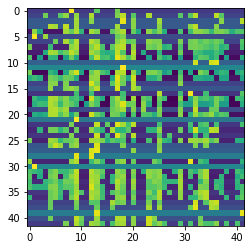

In [137]:
plt.imshow(np.log(A))

#### Matrice confusion

<ipython-input-122-82d623b6e75f>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([ viterbi(i,Pi,A,B)[0] for i in allxT ])
<ipython-input-160-d78038e24595>:10: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(arr))


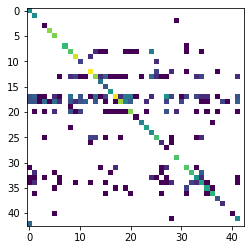

In [160]:
y_true = []
y_pred = []
for q in allqT :
    for i in q :
        y_true.append(i)
for p in predict(Pi,A,B,allxT):
    for i in p :
        y_pred.append(i)
arr = confusion_matrix(y_true, y_pred)
plt.imshow(np.log(arr))

#Blanc -> Pas erreur
# 2 types de Part Of speach on sait classifier car on voit 2 lignes donc demannder a expert pour plus d'info

In [175]:
cles2ind

{'$': 0,
 "''": 1,
 '(': 2,
 ')': 3,
 ',': 4,
 '.': 5,
 ':': 6,
 'CC': 7,
 'CD': 8,
 'DT': 9,
 'EX': 10,
 'FW': 11,
 'IN': 12,
 'JJ': 13,
 'JJR': 14,
 'JJS': 15,
 'MD': 16,
 'NN': 17,
 'NNP': 18,
 'NNPS': 19,
 'NNS': 20,
 'PDT': 21,
 'POS': 22,
 'PRP': 23,
 'PRP$': 24,
 'RB': 25,
 'RBR': 26,
 'RBS': 27,
 'RP': 28,
 'TO': 29,
 'UH': 30,
 'VB': 31,
 'VBD': 32,
 'VBG': 33,
 'VBN': 34,
 'VBP': 35,
 'VBZ': 36,
 'WDT': 37,
 'WP': 38,
 'WP$': 39,
 'WRB': 40,
 '``': 41,
 '#': 42}

# Test d'outils plus avancés

1. On propose de faire des tests avec CRFTagger

[https://tedboy.github.io/nlps/generated/generated/nltk.CRFTagger.html]

1. PerceptronTagger de nltk

1. En dehors de python, vous pouvez facilement utiliser le vénérable TreeTagger qui fonctionne toujours bien (mais pas forcément dans le même référenciel d'étiquetage:
[http://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/]
Il y a même un wrapper python en bas de la page pour intégrer ça dans votre code.
Ce tagger a l'avantage d'avoir des modules pour le français.



In [170]:
# il faut parfois:
!pip install python-crfsuite

In [171]:
from nltk.tag.crf           import CRFTagger

In [172]:
tagger = CRFTagger()
tagger.train(alldocs, 'out/crf.model') # apprentissage

In [ ]:
# mesure de la performance (à aller chercher dans la documentation)
# le même travail qualitatif que précédemment est possible (et souhaitable !)...
# ... Il est aussi très simple si votre code est mis dans des fonctions

# TODO

Check: 1720 bonnes réponses

In [ ]:
# perceptron

from nltk.tag.perceptron    import PerceptronTagger
tagger = PerceptronTagger(load=False)
tagger.train(alldocs)



In [ ]:
# Evaluation

# TODO

Check: 1737 bonnes réponses

# Et sur d'autres applications?

Vous pouvez directement tester toutes les méthodes précédentes sur le chunking en changeant juste la fonction de chargement des données.
Le codage des séquences est très intéressant avec des balises B(egin)/I(n).

Du point de vue industriel, une des tâches les plus importantes est la détection d'entités nommées. Pour attaquer facilement la tâche NER, le dataset CoLNN 2003 est parfait (les datasets correspondant aux années suivantes sont corrects également).
Le codage des séquences est un peu plus compliqué pour le NER.

**Note 1**  Il faut faire attention dans cette tâche à ne calculer les taux de bonne classification que sur les entités et pas sur le tag *O=out*... On peut ensuite calculer une métrique à part pour les faux positifs.

**Note 2** Il créer une nouvelle version du lecteur de données, ce qui constitue un très bon exercice.

**Note 3** Ce jeu de données est encore largement utilisé en recherche: ce travail peut donc figurer dans votre CV :)

**Note 4** Afin de conserver un code plus facile à lire, il peut être utile de traiter cette question dans un nouveau notebook.

Lien vers le site officiel (qui ne contient pas les données!): [https://www.clips.uantwerpen.be/conll2003/ner/]

# Outils de l'état de l'art

Pour aller plus loin, ça vaut le coup de refaire les expériences avec des outils reconnus pour le leurs qualités:
https://github.com/stanfordnlp/stanza/

On dérive vite vers des réseaux de neurones... Qui relèvent plutot du M2 DAC.